In [ ]:
pip uninstall -y qfinuwa

In [ ]:
!pip install qfinuwa

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from qfinuwa import Indicators, Strategy, Backtester, Plotting

In [36]:
class CustomIndicators(Indicators):
    
    def rsi(self, stocks, WINDOW_SIZE = 14):
        # Limit time to trading hours (9:30am to 4:00pm)
        stocks['AAPL']['time'] = pd.to_datetime(stocks['AAPL']['time'])
        stocks['AAPL'] = stocks['AAPL'].set_index('time').between_time('9:30', '16:00').reset_index()
        
        delta = stocks['AAPL']['close'].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        rs_up = up_days.rolling(WINDOW_SIZE).mean()
        rs_down = down_days.rolling(WINDOW_SIZE).mean()
        rsi = 100 - 100 / (1 + rs_up/rs_down)
        return {"rsi": rsi}


2021-05-31 09:43:00
2021-05-31 09:44:00
2021-05-31 09:45:00
2021-05-31 09:46:00
2021-05-31 09:47:00
2021-05-31 09:48:00
2021-05-31 09:49:00
2021-05-31 09:50:00
2021-05-31 09:51:00
2021-05-31 09:52:00
2021-05-31 09:53:00
2021-05-31 09:54:00
2021-05-31 09:55:00
2021-05-31 09:56:00
2021-05-31 09:57:00
2021-05-31 09:58:00
2021-05-31 09:59:00
2021-05-31 10:00:00
2021-05-31 10:01:00
2021-05-31 10:02:00
2021-05-31 10:03:00
2021-05-31 10:04:00
2021-05-31 10:05:00
2021-05-31 10:06:00
2021-05-31 10:07:00
2021-05-31 10:08:00
2021-05-31 10:09:00
2021-05-31 10:10:00
2021-05-31 10:11:00
2021-05-31 10:12:00
2021-05-31 10:13:00
2021-05-31 10:14:00
2021-05-31 10:15:00
2021-05-31 10:16:00
2021-05-31 10:17:00
2021-05-31 10:18:00
2021-05-31 10:19:00
2021-05-31 10:20:00
2021-05-31 10:21:00
2021-05-31 10:22:00
2021-05-31 10:23:00
2021-05-31 10:24:00
2021-05-31 10:25:00
2021-05-31 10:26:00
2021-05-31 10:27:00
2021-05-31 10:28:00
2021-05-31 10:29:00
2021-05-31 10:30:00
2021-05-31 10:31:00
2021-05-31 10:32:00


<Axes: >

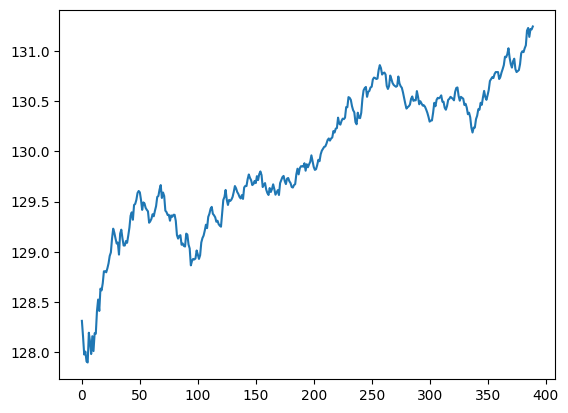

In [90]:
ci = CustomIndicators()
data = ['AAPL']
stocks = {d: pd.read_csv('../data/' + d + '.csv') for d in data}

WINDOW_SIZE = 14
# Limit time to trading hours (9:30am to 4:00pm)
stocks['AAPL']['time'] = pd.to_datetime(stocks['AAPL']['time'])
stocks['AAPL'] = stocks['AAPL'].set_index('time').between_time('9:30', '16:00').reset_index()

delta = stocks['AAPL']['close'].diff()
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
rs_up = up_days.rolling(WINDOW_SIZE).mean()
rs_down = down_days.rolling(WINDOW_SIZE).mean()
rsi = 100 - 100 / (1 + rs_up/rs_down)
stocks['AAPL']['rsi'] = rsi
# look through RSI values and prin tthe row where RSI = 100
# prints the date
for index, row in stocks['AAPL'].iterrows():
    if row['rsi'] == 100:
        print(row)
day_1 = stocks['AAPL'].head(390)
# day_1['rsi'].plot()
day_1['close'].plot()

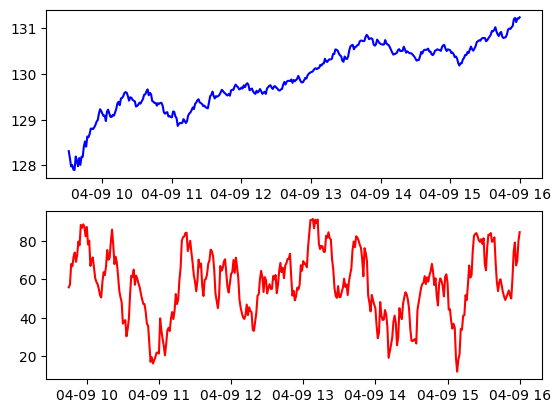

In [89]:
# Create two subplots on top of each other
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot the first graph on the top subplot
ax1.plot(day_1['time'], day_1['close'], color='blue')

# Plot the second graph on the bottom subplot
ax2.plot(day_1['time'], day_1['rsi'], color='red')

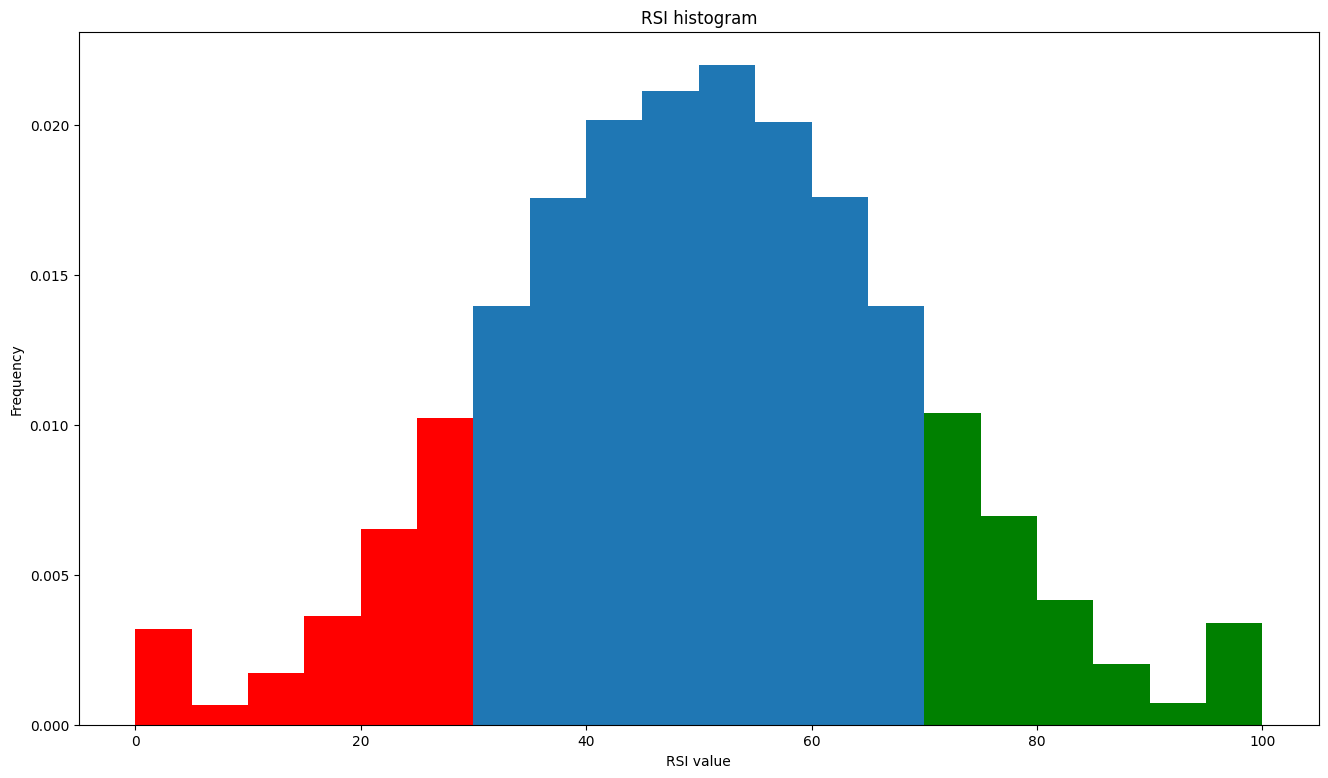

<Figure size 1600x900 with 0 Axes>

In [68]:
fig = plt.figure(figsize=(16,9))
# Create a histogram with 50 bins
n, bins, patches = plt.hist(rsi, 20, density=True)

# Set the color of the histogram bars based on the bin values
for i in range(len(patches)):
    if bins[i] >= 70:
        patches[i].set_fc('g')
    elif bins[i] < 30:
        patches[i].set_fc('r')

plt.xlabel('RSI value')
plt.ylabel('Frequency')
plt.title('RSI histogram')
plt.figure(figsize=(16,9))
plt.show()

In [41]:
class PairsTrading(Strategy):

    def __init__(self, quantity=5):
        self.quantity = quantity
        self.vgt_position = 0
        self.iyw_position = 0

    def on_data(self, prices, indicators, portfolio): 
        # On average, VGT is 4.05 times more expensive than IYW

        # If z_score is greater than 3, buy VGT and sell IYW
        if indicators['z_score'][-1] > 3 and abs(self.vgt_position < 250) and abs(self.iyw_position < 1000):
            portfolio.order('VGT', quantity = self.quantity)
            portfolio.order('IYW', quantity = -4*self.quantity)
            self.vgt_position += self.quantity
            self.iyw_position -= self.quantity
        
        # If z_score is greater than 1.5, buy VGT and sell IYW to half delta limit
        if indicators['z_score'][-1] > 1.5 and abs(self.vgt_position < 125) and abs(self.iyw_position < 500):
            portfolio.order('VGT', quantity = self.quantity)
            portfolio.order('IYW', quantity = -4*self.quantity)
            self.vgt_position += self.quantity
            self.iyw_position -= self.quantity
        
        # If z_score is less than -3, buy IYW and sell VGT
        elif indicators['z_score'][-1] < -3 and abs(self.vgt_position < 250) and abs(self.iyw_position < 1000):
            portfolio.order('VGT', quantity = -self.quantity)
            portfolio.order('IYW', quantity = 4*self.quantity)
            self.vgt_position -= self.quantity
            self.iyw_position += self.quantity

        # If z_score is less than -1.5, buy IYW and sell VGT to half delta limit
        elif indicators['z_score'][-1] < -1.5 and abs(self.vgt_position < 125) and abs(self.iyw_position < 500):
            portfolio.order('VGT', quantity = -self.quantity)
            portfolio.order('IYW', quantity = 4*self.quantity)
            self.vgt_position -= self.quantity
            self.iyw_position += self.quantity
        
        elif abs(indicators['z_score'][-1]) < 1 and abs(self.vgt_position > 125) and abs(self.iyw_position > 500):
            portfolio.order('VGT', quantity = -self.vgt_position)
            portfolio.order('IYW', quantity = -self.iyw_position)
        
        # If z_score is between -0.5 and 0.5, exit positions
        elif abs(indicators['z_score'][-1]) < 0.5:
            portfolio.order('VGT', quantity = -self.vgt_position)
            portfolio.order('IYW', quantity = -self.iyw_position)
        return
    
    def on_finish(self):
        return self.vgt_position, self.iyw_position
        

In [ ]:
class ORB(Strategy):

    def __init__(self, quantity=5):
        self.quantity = quantity
        self.vgt_position = 0
        self.iyw_position = 0

    def on_data(self, prices, indicators, portfolio): 
        # On average, VGT is 4.05 times more expensive than IYW

        # If z_score is greater than 3, buy VGT and sell IYW
        if indicators['z_score'][-1] > 3 and abs(self.vgt_position < 250) and abs(self.iyw_position < 1000):
            portfolio.order('VGT', quantity = self.quantity)
            portfolio.order('IYW', quantity = -4*self.quantity)
            self.vgt_position += self.quantity
            self.iyw_position -= self.quantity
        
        # If z_score is greater than 1.5, buy VGT and sell IYW to half delta limit
        if indicators['z_score'][-1] > 1.5 and abs(self.vgt_position < 125) and abs(self.iyw_position < 500):
            portfolio.order('VGT', quantity = self.quantity)
            portfolio.order('IYW', quantity = -4*self.quantity)
            self.vgt_position += self.quantity
            self.iyw_position -= self.quantity
        
        # If z_score is less than -3, buy IYW and sell VGT
        elif indicators['z_score'][-1] < -3 and abs(self.vgt_position < 250) and abs(self.iyw_position < 1000):
            portfolio.order('VGT', quantity = -self.quantity)
            portfolio.order('IYW', quantity = 4*self.quantity)
            self.vgt_position -= self.quantity
            self.iyw_position += self.quantity

        # If z_score is less than -1.5, buy IYW and sell VGT to half delta limit
        elif indicators['z_score'][-1] < -1.5 and abs(self.vgt_position < 125) and abs(self.iyw_position < 500):
            portfolio.order('VGT', quantity = -self.quantity)
            portfolio.order('IYW', quantity = 4*self.quantity)
            self.vgt_position -= self.quantity
            self.iyw_position += self.quantity
        
        elif abs(indicators['z_score'][-1]) < 1 and abs(self.vgt_position > 125) and abs(self.iyw_position > 500):
            portfolio.order('VGT', quantity = -self.vgt_position)
            portfolio.order('IYW', quantity = -self.iyw_position)
        
        # If z_score is between -0.5 and 0.5, exit positions
        elif abs(indicators['z_score'][-1]) < 0.5:
            portfolio.order('VGT', quantity = -self.vgt_position)
            portfolio.order('IYW', quantity = -self.iyw_position)
        return
    
    def on_finish(self):
        return self.vgt_position, self.iyw_position

In [42]:
backtester = Backtester(ORB, CustomIndicators, ['AApl'], data_folder='../data', days=30, fee=0.000, delta_limits=1000)
backtester

> Precompiling data: 100%|██████████| 431430/431430 [01:06<00:00, 6503.40it/s] 


Backtester:
- Strategy: PairsTrading
	- Params: {'quantity': 5}
- Indicators: CustomIndicators
	- Params: {'pairs_ratio': {'WINDOW_SIZE': 1440}}
	- SingleIndicators: ['z_score']
	- MultiIndicators: []
- Stocks: ['IYW', 'VGT']
- Fee 0.0
- delta_limit: {'IYW': 1000, 'VGT': 1000}
- Days: 30

In [43]:
backtester.run(cv=20)

> Running backtest over 20 samples of 30 days: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]



{'strategy': {'quantity': 5}, 'indicator': {'pairs_ratio': {'WINDOW_SIZE': 1440}}}

Mean ROI:	106488.35509343888
STD ROI:	233341.52350331252

01/07/2022 -> 29/07/2022:	278104.745
10/05/2022 -> 08/06/2022:	183635.436
29/09/2022 -> 28/10/2022:	-252678.757
21/04/2022 -> 20/05/2022:	252531.100
08/10/2021 -> 05/11/2021:	223380.607
10/01/2022 -> 08/02/2022:	212640.262
27/10/2021 -> 25/11/2021:	-291670.606
17/03/2022 -> 15/04/2022:	241258.144
07/11/2022 -> 06/12/2022:	-292946.047
10/08/2022 -> 08/09/2022:	272925.765
15/04/2021 -> 14/05/2021:	182893.684
29/06/2021 -> 28/07/2021:	302688.711
28/01/2022 -> 25/02/2022:	-122306.547
07/07/2021 -> 05/08/2021:	306956.581
28/05/2021 -> 25/06/2021:	290332.384
21/07/2022 -> 19/08/2022:	297714.795
14/04/2021 -> 13/05/2021:	274904.847
09/07/2021 -> 06/08/2021:	-209044.185
09/02/2022 -> 10/03/2022:	-286182.892
04/05/2022 -> 02/06/2022:	264629.074

AVERAGED RESULTS FOR 20 RUNS:
|               |     IYW |      VGT |     Net |
|---------------|---------|----

In [69]:
backtester.run_grid_search(
    strategy_params={'quantity': [5, 10]},
    indicator_params={'pairs_ratio': {'WINDOW_SIZE': [10, 30, 50, 100]}},
    cv=20)

> Backtesting the across the following ranges:
Agorithm Parameters {'quantity': [5, 10]}
Indicator Parameters {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 50}, 'pairs_ratio': {'WINDOW_SIZE': [10, 30, 50, 100]}}


Running paramter sweep (cv=20): 100%|██████████| 8/8 [02:00<00:00, 15.05s/it]


Best parameter results:

{'strategy': {'quantity': 5}, 'indicator': {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 50}, 'pairs_ratio': {'WINDOW_SIZE': 30}}}

Mean ROI:	156909.20364754897
STD ROI:	93090.73333407863

24/05/2022 -> 22/06/2022:	27583.434
22/07/2022 -> 19/08/2022:	-12033.717
05/05/2022 -> 03/06/2022:	171005.386
19/07/2022 -> 17/08/2022:	270222.067
04/03/2022 -> 01/04/2022:	138562.573
28/01/2022 -> 25/02/2022:	59917.444
27/07/2021 -> 25/08/2021:	21183.580
29/09/2021 -> 28/10/2021:	316272.082
22/07/2021 -> 20/08/2021:	201960.922
15/06/2021 -> 14/07/2021:	174107.061
26/07/2022 -> 24/08/2022:	238021.482
09/02/2022 -> 10/03/2022:	162223.991
07/02/2022 -> 08/03/2022:	109613.841
03/08/2022 -> 01/09/2022:	241547.968
18/03/2022 -> 15/04/2022:	220591.896
17/09/2021 -> 15/10/2021:	323980.553
09/04/2021 -> 07/05/2021:	108221.926
20/04/2021 -> 19/05/2021:	128155.390
04/01/2022 -> 02/02/2022:	68501.283
07/09/2021 -> 06/10/2021:	168544.909

AVERAGED RESULTS FOR 20 RUNS:
|      

In [39]:
output = backtester.run(cv=3)
Plotting.plot_result(output[0], stocks=['VGT', 'IYW'], show_transactions = True, show_portfolio=False)

> Running backtest over 3 samples of 30 days: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
